In [1]:
import crossref_commons.retrieval
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
from src.crossref import current_timestamp
from src.github_api import ReplicationCode
from time import sleep

# GitHub API

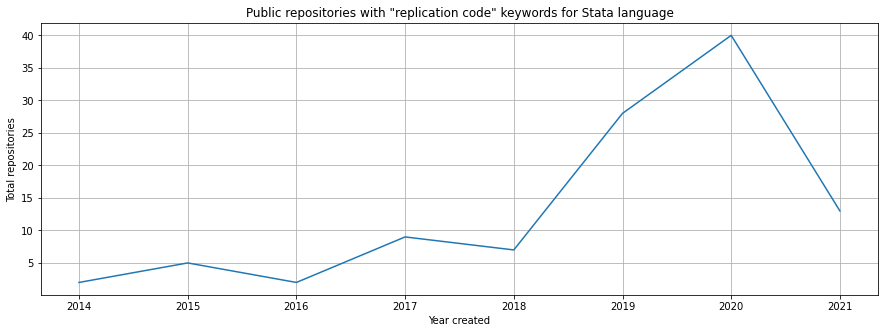

In [2]:
rc = ReplicationCode()
ghapi = rc.dataframe()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('created_at', 'count', data=ghapi)
plt.grid(b=True)
plt.title('Public repositories with "replication code" keywords for Stata language')
plt.xlabel('Year created')
plt.ylabel('Total repositories')
plt.savefig('img/replication-code-stata.png', bbox_inches = 'tight')

# AEA Deposits on ICPSR 

In [3]:
# check whether all data have been downloaded
!python3 src/aea.py --help
!python3 src/aea.py -j aer
!python3 src/aea.py -j aeri
!python3 src/aea.py -j app
!python3 src/aea.py -j pol
!python3 src/aea.py -j mac
!python3 src/aea.py -j mic
!python3 src/aea.py -j jel
!python3 src/aea.py -j jep
!python3 src/aea.py -j pandp

usage: aea.py [-h] [-j]

optional arguments:
  -h, --help       show this help message and exit
  -j , --journal   Journal name: ['aer', 'aeri', 'app', 'pol', 'mac', 'mic',
                   'jel', 'jep', 'pandp']
2021-05-12 00:57:37: https://www.aeaweb.org/journals/aer/issues
2021-05-12 00:57:39: https://www.aeaweb.org/journals/aeri/issues
2021-05-12 00:57:40: https://www.aeaweb.org/journals/app/issues
2021-05-12 00:57:42: https://www.aeaweb.org/journals/pol/issues
2021-05-12 00:57:43: https://www.aeaweb.org/journals/mac/issues
2021-05-12 00:57:45: https://www.aeaweb.org/journals/mic/issues
2021-05-12 00:57:46: https://www.aeaweb.org/journals/jel/issues
2021-05-12 00:57:48: https://www.aeaweb.org/journals/jep/issues
2021-05-12 00:57:49: https://www.aeaweb.org/journals/pandp/issues


In [4]:
aea = os.listdir('data/aea/raw')

In [5]:
def dataframe(file):
    with open(f'data/aea/raw/{file}', 'r') as f:
        data = json.load(f)

    df = pd.DataFrame(data['article'])
    df.insert(0, 'issue_url', data['issue_url'])
    df.insert(1, 'publication_date', data['publication_date'])

    return df

In [6]:
df = pd.concat([dataframe(x) for x in aea], sort=False)
df = df.reset_index(drop=True)
df['year'] = df.publication_date.apply(lambda x: x[-4:])
df['year'] = df.year.astype(str)

In [7]:
size = df.groupby('year')['icpsr'].size()
count = df.groupby('year')['icpsr'].count()
icpsr = pd.merge(size, count, on='year')
icpsr['proportion'] = icpsr.icpsr_y / icpsr.icpsr_x
icpsr = icpsr.reset_index()

In [8]:
def monthly():
    # will be used for monthly
    dates = []
    base_date = icpsr.publication_date.min()
    while base_date <= icpsr.publication_date.max():
        if base_date.day == 1:
            dates.append(base_date)
        base_date += timedelta(days=1)
    datesdf = pd.DataFrame(sorted(dates), columns=['publication_date'])

    icpsr = pd.merge(datesdf, icpsr, how='left', on='publication_date')
    icpsr.percent = icpsr.percent.fillna(0)
    
    return icpsr

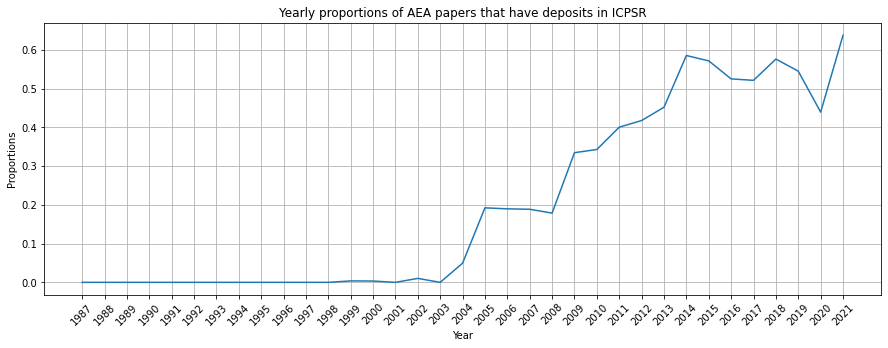

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot('year', 'proportion', data=icpsr)
plt.grid(b=True)
plt.title('Yearly proportions of AEA papers that have deposits in ICPSR')
plt.xticks(rotation = 45)
plt.xlabel('Year')
plt.ylabel('Proportions')
plt.savefig('img/aea-deposit-icpsr.png', bbox_inches = 'tight')

# Top 10 econ journals

In [10]:
def check_column(data, column):
    try:
        return data[column]
    except KeyError:
        return None
    
def dataframe(path, journal, file_name):
    df = []
    for j in journal:
        with open(f'{path}/{j}', 'r') as f:
            data = json.load(f)
            url = data['URL']
            print(f'{current_timestamp()}: {url}')
            d = {
                'doi': url,
                'title': check_column(data, 'title'),
                'author': check_column(data, 'author'),
                'publisher': check_column(data, 'publisher'),
                'created': check_column(data, 'created'),
                'has_replication': has_replication(url)

            }
            df.append(d)

    pd.DataFrame(df).to_csv(f'data/has-replication/{file_name}.csv', index=False)

## American Economic Association

AEA has three journals that are listed in top 10 econ journals according to IDEAS/RePEc. They are:
- American Economic Review (#1)
- Journal of Economic Literature (#2)
- Journal of Economic Perspectives (#10)

In [11]:
path = 'data/aea/raw'
os.system(f'rm -rf {path}/.ipynb_checkpoints')
aea = os.listdir(path)
aea = [json.load(open(f'{path}/{x}', 'r')) for x in aea]

In [12]:
for i in aea:
    for j in i['article']:
        j.update({'publication_date': i['publication_date']})

In [13]:
def has_replication(journal, file_name):
    df = pd.concat([pd.DataFrame(x['article']) for x in aea], sort=False)
    df = df.reset_index(drop=True)
    df['has_replication'] = df.icpsr.apply(lambda x: x != None)
    df[journal] = df.url.apply(lambda x: f'{journal}.' in x.lower())
    df = df[df[journal] == True]
    df = df[['url', 'icpsr', 'publication_date', 'has_replication']]
    df = df.reset_index(drop=True)
    df.to_csv(f'data/has-replication/{file_name}.csv', index=False)
    
has_replication('aer', 'american-economic-review')
has_replication('jel', 'journal-of-economic-literature')
has_replication('jep', 'journal-of-economic-perspectives')

## 3. The Quarterly Journal of Economics

In [14]:
path = 'data/crossref/s-oup-qjecon'
qje = os.listdir(path)

def has_replication(url):
    '''
    DOI example that has supplementary data: https://doi.org/10.1093/qje/qjaa038
    DOI example that doesn't have any supplementary data: http://dx.doi.org/10.1093/qje/qjr049
    '''

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            return content.find('h2', {'id': 'supplementary-data'}) != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, qje, 'the-quarterly-journal-of-economics')

2021-05-12 00:57:53: http://dx.doi.org/10.1162/qjec.2006.121.2.673
2021-05-12 00:57:57: http://dx.doi.org/10.1162/0033553042476161
2021-05-12 00:57:59: http://dx.doi.org/10.1093/qje/qjv022
2021-05-12 00:58:03: http://dx.doi.org/10.1093/qje/120.3.835
2021-05-12 00:58:05: http://dx.doi.org/10.1162/qjec.2008.123.3.1161
2021-05-12 00:58:08: http://dx.doi.org/10.1162/00335530360698469
2021-05-12 00:58:10: http://dx.doi.org/10.1162/003355301753265606
2021-05-12 00:58:12: http://dx.doi.org/10.1093/qje/qjv011
2021-05-12 00:58:16: http://dx.doi.org/10.1093/qje/qjx030
2021-05-12 00:58:20: http://dx.doi.org/10.1162/qjec.2007.122.4.1351
2021-05-12 00:58:23: http://dx.doi.org/10.1093/qje/qjs076
2021-05-12 00:58:23: http://dx.doi.org/10.1162/qjec.2009.124.1.1
2021-05-12 00:58:26: http://dx.doi.org/10.1162/003355304772839542
2021-05-12 00:58:28: http://dx.doi.org/10.1093/qje/qjt002
2021-05-12 00:58:31: http://dx.doi.org/10.1162/qjec.2008.123.3.905
2021-05-12 00:58:33: http://dx.doi.org/10.1162/qjec.2

## 5. Journal of Political Economy

In [15]:
path = 'data/crossref/s-ucp-jpolec'
jpolec = os.listdir(path)

def has_replication(url):
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            sleep(1)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            div = content.find('div', {'class': 'article__navbar__row tos-list__wrapper'})
            try:
                return 'supplemental material' in [x.text.lower() for x in div.find_all('li')]
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, jpolec, 'journal-of-political-economy')

2021-05-12 01:04:27: http://dx.doi.org/10.1086/670137
2021-05-12 01:04:29: http://dx.doi.org/10.1086/694622
2021-05-12 01:04:31: http://dx.doi.org/10.1086/660887
2021-05-12 01:04:34: http://dx.doi.org/10.1086/706861
2021-05-12 01:04:36: http://dx.doi.org/10.1086/656513
2021-05-12 01:04:38: http://dx.doi.org/10.1086/676597
2021-05-12 01:04:40: http://dx.doi.org/10.1086/514347
2021-05-12 01:04:43: http://dx.doi.org/10.1086/701030
2021-05-12 01:04:45: http://dx.doi.org/10.1086/701890
2021-05-12 01:04:47: http://dx.doi.org/10.1086/694292
2021-05-12 01:04:49: http://dx.doi.org/10.1086/706983
2021-05-12 01:04:51: http://dx.doi.org/10.1086/700732
2021-05-12 01:04:53: http://dx.doi.org/10.1086/705670
2021-05-12 01:04:55: http://dx.doi.org/10.1086/589522
2021-05-12 01:04:57: http://dx.doi.org/10.1086/700765
2021-05-12 01:04:59: http://dx.doi.org/10.1086/650478
2021-05-12 01:05:01: http://dx.doi.org/10.1086/676405
2021-05-12 01:05:03: http://dx.doi.org/10.1086/668864
2021-05-12 01:05:05: http://

## 6. Journal of Economic Growth 

In [16]:
path = 'data/crossref/s-kap-jecgro'
jecgro = os.listdir(path)

def has_replication(url):
    '''
    DOI example with Electronic supplementary material: https://doi.org/10.1007/s10887-020-09183-6
    DOI example with Supplementary Information: https://doi.org/10.1007/s10887-020-09185-4
    '''
    
    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplement = lambda keyword: content.find('section', {'data-title': keyword}).text.lower()
            try:
                return 'supplementary material' in supplement('Electronic supplementary material')
            except AttributeError:
                try:
                    return 'supplementary material' in supplement('Supplementary Information')
                except AttributeError:
                    return False
            except Exception as e:
                print(f'{current_timestamp()}: {url} has an error -> {e}')
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass

dataframe(path, jecgro, 'journal-of-economic-growth')

2021-05-12 01:24:10: http://dx.doi.org/10.1007/s10887-008-9033-7
2021-05-12 01:24:12: http://dx.doi.org/10.1007/s10887-017-9140-4
2021-05-12 01:24:13: http://dx.doi.org/10.1007/s10887-015-9118-z
2021-05-12 01:24:15: http://dx.doi.org/10.1007/s10887-008-9035-5
2021-05-12 01:24:17: http://dx.doi.org/10.1007/s10887-006-9001-z
2021-05-12 01:24:18: http://dx.doi.org/10.1007/s10887-020-09185-4
2021-05-12 01:24:20: http://dx.doi.org/10.1007/s10887-006-9004-9
2021-05-12 01:24:21: http://dx.doi.org/10.1007/s10887-009-9039-9
2021-05-12 01:24:23: http://dx.doi.org/10.1007/s10887-007-9023-1
2021-05-12 01:24:24: http://dx.doi.org/10.1007/s10887-006-9008-5
2021-05-12 01:24:26: http://dx.doi.org/10.1007/s10887-009-9044-z
2021-05-12 01:24:27: http://dx.doi.org/10.1007/s10887-016-9125-8
2021-05-12 01:24:29: http://dx.doi.org/10.1007/s10887-017-9141-3
2021-05-12 01:24:31: http://dx.doi.org/10.1007/s10887-007-9013-3
2021-05-12 01:24:32: http://dx.doi.org/10.1007/s10887-014-9107-7
2021-05-12 01:24:34: htt

## 7. Review of Financial Studies

In [17]:
path = 'data/crossref/s-oup-rfinst'
rfinst = os.listdir(path)

def has_replication(url):

    status_code = None
    while status_code not in [200, 404]:
        try:
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            print(res)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            supplementary = content.find('h2', {'id': 'supplementary-data'})
            return supplementary != None
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, rfinst, 'the-review-of-financial-studies')

2021-05-12 01:30:09: http://dx.doi.org/10.1093/rfs/hhu038
<Response [200]>
2021-05-12 01:30:10: http://dx.doi.org/10.1093/rfs/hhy102
<Response [200]>
2021-05-12 01:30:11: http://dx.doi.org/10.1093/rfs/hhz131
<Response [200]>
2021-05-12 01:30:12: http://dx.doi.org/10.1093/rfs/hhaa062
<Response [200]>
2021-05-12 01:30:13: http://dx.doi.org/10.1093/rfs/hhx127
<Response [200]>
2021-05-12 01:30:14: http://dx.doi.org/10.1093/rfs/hhz099
<Response [200]>
2021-05-12 01:30:15: http://dx.doi.org/10.1093/rfs/hht012
<Response [200]>
2021-05-12 01:30:16: http://dx.doi.org/10.1093/rfs/hhz015
<Response [200]>
2021-05-12 01:30:16: http://dx.doi.org/10.1093/rfs/hhw075
<Response [200]>
2021-05-12 01:30:17: http://dx.doi.org/10.1093/rfs/hht064
<Response [200]>
2021-05-12 01:30:18: http://dx.doi.org/10.1093/rfs/hhaa073
<Response [200]>
2021-05-12 01:30:19: http://dx.doi.org/10.1093/rfs/hhy042
<Response [200]>
2021-05-12 01:30:19: http://dx.doi.org/10.1093/rfs/hhy057
<Response [200]>
2021-05-12 01:30:20: ht

## 8. Econometrica 

In [18]:
path = 'data/crossref/s-wly-emetrp'
econometrica = os.listdir(path)

def has_replication(url):
    status_code = []
    while status_code not in [200, 404]:
        try:
            res = requests.get(url)
            status_code = res.status_code
            content = BeautifulSoup(res.content, features='html.parser')
            try:
                article = content.find('article')
                return 'replication' in article.text.lower()
            except:
                return False
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass
        
dataframe(path, econometrica, 'econometrica')

2021-05-12 01:35:40: http://dx.doi.org/10.3982/ecta16410
2021-05-12 01:35:42: http://dx.doi.org/10.3982/ecta15867
2021-05-12 01:35:45: http://dx.doi.org/10.3982/ecta15579
2021-05-12 01:35:46: http://dx.doi.org/10.3982/ecta14084
2021-05-12 01:35:48: http://dx.doi.org/10.3982/ecta11905
2021-05-12 01:35:51: http://dx.doi.org/10.3982/ecta16475
2021-05-12 01:35:52: http://dx.doi.org/10.3982/ecta15949
2021-05-12 01:35:54: http://dx.doi.org/10.3982/ecta14138
2021-05-12 01:35:56: http://dx.doi.org/10.3982/ecta14044
2021-05-12 01:35:58: http://dx.doi.org/10.3982/ecta16557
2021-05-12 01:36:01: http://dx.doi.org/10.3982/ecta15676
2021-05-12 01:36:02: http://dx.doi.org/10.3982/ecta13758
2021-05-12 01:36:04: http://dx.doi.org/10.3982/ecta19347
2021-05-12 01:36:05: http://dx.doi.org/10.3982/ecta10266
2021-05-12 01:36:06: http://dx.doi.org/10.3982/ecta16901
2021-05-12 01:36:08: http://dx.doi.org/10.3982/ecta13673
2021-05-12 01:36:09: http://dx.doi.org/10.3982/ecta16756
2021-05-12 01:36:12: http://dx.

## 9. Journal of Finance

In [19]:
path = 'data/crossref/s-bla-jfinan'
jfinan = os.listdir(path)

def _jfinan_crossref():
    dfs = []
    for i in jfinan:
        with open(f'{path}/{i}', 'r') as f:
            data = json.load(f)
        d = {
            'doi': data['URL'],
            'title': check_column(data, 'title'),
            'author': check_column(data, 'author'),
            'publisher': check_column(data, 'publisher'),
            'created': check_column(data, 'created'),
            'has_replication': False

        }

        dfs.append(pd.DataFrame([d]))

    df = pd.concat(dfs, sort=False)
    
    return df

def has_replication():
    status_code = None
    while status_code not in [200, 404]:
        try:
            url = 'https://afajof.org/supplements/'
            res = requests.get(url, headers={'user-agent': os.environ['USER_AGENT']})
            status_code = res.status_code
        except Exception as e:
            print(f'{current_timestamp()}: {url} has an error -> {e}')
            pass        
    content = BeautifulSoup(res.content, features='html.parser')
    div = content.find('div', {'class': 'site-content-contain'})
    doi = [x.text for x in div.find_all('p') if 'doi' in x.text]
    crossref = [crossref_commons.retrieval.get_publication_as_json(x) for x in doi]
    dfs = []
    for i in crossref:
        d = {
            'doi': i['URL'],
            'title': check_column(i, 'title'),
            'author': check_column(i, 'author'),
            'publisher': check_column(i, 'publisher'),
            'created': check_column(i, 'created'),
            'has_replication': True

        }
        dfs.append(pd.DataFrame([d]))
        file_name = i['DOI'].replace('/', '-')
        with open(f'{path}/{file_name}', 'w') as f:
            json.dump(i, f, indent=4)
    
    df = pd.concat(dfs, sort=False)
    
    return df

df = pd.concat([_jfinan_crossref(), has_replication()], sort=False)
df.to_csv('data/has-replication/journal-of-finance.csv', index=False)